In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img




In [2]:
#########################################################################3
##  PREPARE OUR DATA


# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-2
BATCH_SIZE = 512
NUM_EPOCHS = 20

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255)#,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data_mono/train',  # this is the target directory
        color_mode='grayscale',
        target_size=(64, 64),  # all images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data_mono/validation',
        color_mode='grayscale',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        class_mode='binary')


##########################################################################


Found 133594 images belonging to 2 classes.
Found 14038 images belonging to 2 classes.


In [7]:
class Mono_Model(Model):
    def __init__(self):
        super(Mono_Model, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = Mono_Model()

In [3]:
class Multi_Model(Model):
    def __init__(self):
        super(Multi_Model, self).__init__()
        
        noise = 0.1
        self.batch0 = BatchNormalization()

        self.gauss1 = GaussianNoise(noise)
        self.conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')
        self.batch1 = BatchNormalization()
        self.maxpool1 = MaxPooling2D((2, 2), padding='same')

        self.gauss2 = GaussianNoise(noise)
        self.conv2 = Conv2D(32, (5, 5), activation='relu', padding='same')
        self.batch2 = BatchNormalization()
        self.maxpool2 = MaxPooling2D((2, 2), padding='same')

        self.gauss3 = GaussianNoise(noise)
        self.conv3 = Conv2D(16, (5, 5), activation='relu', padding='same')
        self.batch3 = BatchNormalization()
        self.maxpool3 = MaxPooling2D((2, 2), padding='same')

        self.gauss4 = GaussianNoise(noise)
        self.conv4 = Conv2D(32, (5, 5), activation='relu', padding='same')
        self.batch4 = BatchNormalization()
        self.maxpool4 = MaxPooling2D((2, 2), padding='same')

        self.flatten = Flatten()
        self.d1 = Dense(512, activation='relu')
        self.drp1 = Dropout(0.3)
        self.d2 = Dense(256, activation='relu')
        self.drp2 = Dropout(0.5)
        self.d3 = Dense(64, activation='relu')
        self.d4 = Dense(1, activation='sigmoid')
        #self.d4 = Dense(3, activation='softmax')
        


    def call(self, x):
        x = self.batch0(x)

        x = self.gauss1(x)
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.maxpool1(x)

        x = self.gauss2(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.maxpool2(x)

        x = self.gauss3(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.maxpool3(x)

        x = self.gauss4(x)
        x = self.conv4(x)
        x = self.batch4(x)
        x = self.maxpool4(x)

        x = self.flatten(x)
        x = self.d1(x)
        x = self.drp1(x)
        x = self.d2(x)
        x = self.drp2(x)
        x = self.d3(x)
        x = self.d4(x)

        return x

# Create an instance of the model
model = Multi_Model()



In [5]:
###################################################

if False:
    # initialize the optimizer compile the model and
    opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
    print("[INFO] training network...")
    model.compile(loss="binary_crossentropy", optimizer=opt,
            metrics=["accuracy"])

else:
    model.compile(optimizer='adam',
                  loss="binary_crossentropy",
                  metrics=['accuracy'])


modelName = './Mono_1'
#checkpointer = ModelCheckpoint(modelName, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
checkpointer = ModelCheckpoint(modelName, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

# train the network
H = model.fit(
        train_generator,
        epochs=NUM_EPOCHS,
        steps_per_epoch=133000 // BATCH_SIZE,
        shuffle=True,
        verbose=1,        
        validation_data=validation_generator,
        validation_steps=13400 // BATCH_SIZE,
        #callbacks=[checkpointer])
        callbacks=[checkpointer, earlystop])


# save as Model
#model.save('Mono_64')


Epoch 1/20
259/259 [==============================] - 54s 198ms/step - loss: 0.2361 - accuracy: 0.9148 - val_loss: 4.0745 - val_accuracy: 0.1954
Epoch 2/20
259/259 [==============================] - 41s 157ms/step - loss: 0.0605 - accuracy: 0.9824 - val_loss: 0.0820 - val_accuracy: 0.9730
Epoch 3/20
259/259 [==============================] - 40s 156ms/step - loss: 0.0433 - accuracy: 0.9882 - val_loss: 0.0409 - val_accuracy: 0.9884
Epoch 4/20
259/259 [==============================] - 40s 153ms/step - loss: 0.0378 - accuracy: 0.9893 - val_loss: 0.0455 - val_accuracy: 0.9880
Epoch 5/20
259/259 [==============================] - 39s 151ms/step - loss: 0.0330 - accuracy: 0.9906 - val_loss: 0.0353 - val_accuracy: 0.9907
Epoch 6/20
259/259 [==============================] - 40s 154ms/step - loss: 0.0308 - accuracy: 0.9907 - val_loss: 0.0330 - val_accuracy: 0.9902
Epoch 7/20
259/259 [==============================] - 39s 152ms/step - loss: 0.0274 - accuracy: 0.9917 - val_loss: 0.0334 - val_ac

In [9]:
model.evaluate(validation_generator)

28/28 [==============================] - 4s 139ms/step - loss: 0.0277 - accuracy: 0.9918


[0.027710724622011185, 0.9918079376220703]

In [8]:
# save as Model
model.load_weights(modelName)

model.save('Mono_64_completo')

INFO:tensorflow:Assets written to: Mono_64_completo/assets


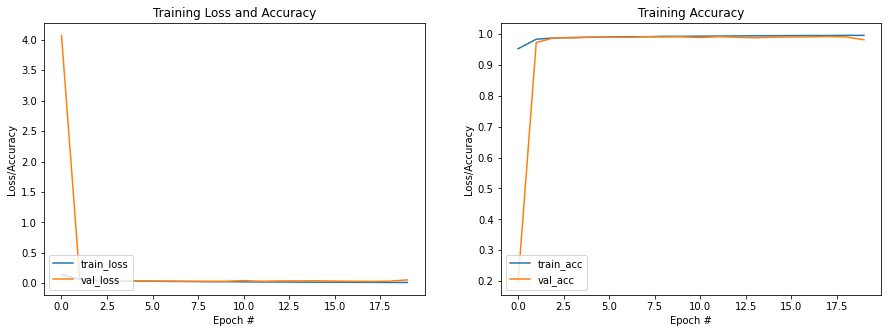

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
#plt.style.use("ggplot")
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.subplot(122)
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [10]:
def plot_list(idxs, imgs):
    new_size = [64, 64]
    columns = 10
    rows = int(np.ceil(len(idxs)/columns))
    images = np.zeros((rows * imgs.shape[1],columns*imgs.shape[2]))

    for j,ids in enumerate(idxs):

        row = int(np.floor(j/columns))
        column = j%columns

        images[row*new_size[0]:(row+1)*new_size[0], column*new_size[1]:(column+1)*new_size[1]] = imgs[ids,:,:,0]

    plt.figure(figsize=(20,10))
    plt.imshow(images)
    plt.grid(b=None)
    plt.show()

(512, 64, 64, 1) (512,)


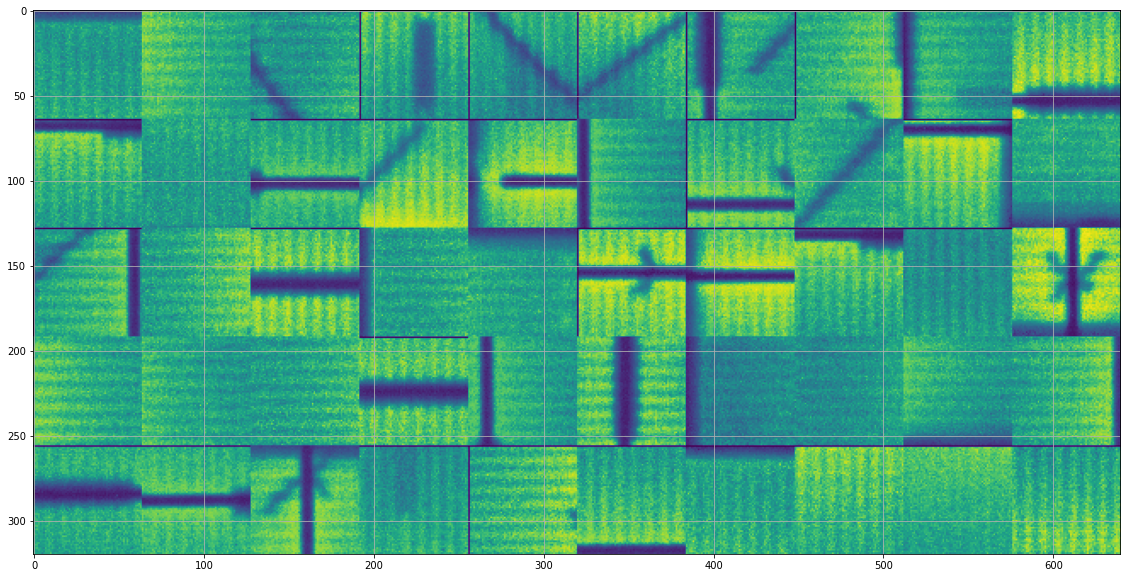

(512, 64, 64, 1) (512,)


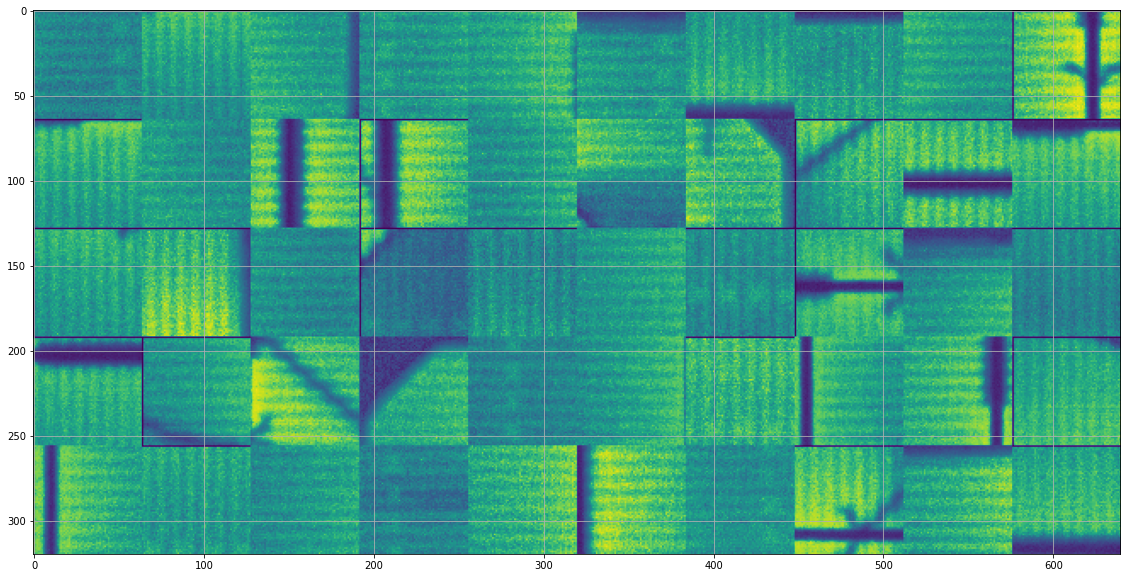

(512, 64, 64, 1) (512,)


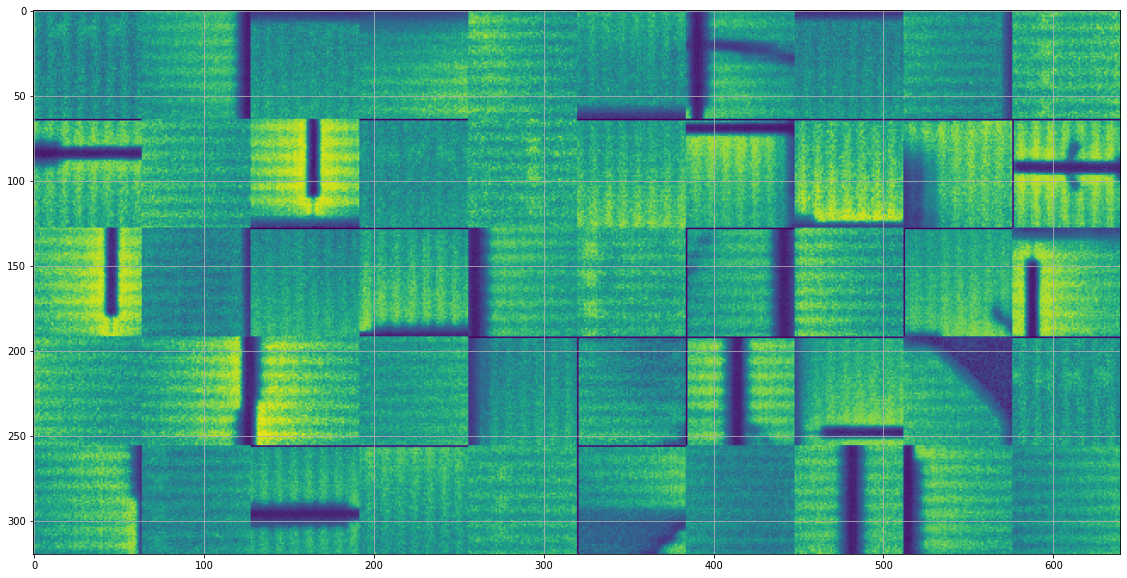

(512, 64, 64, 1) (512,)


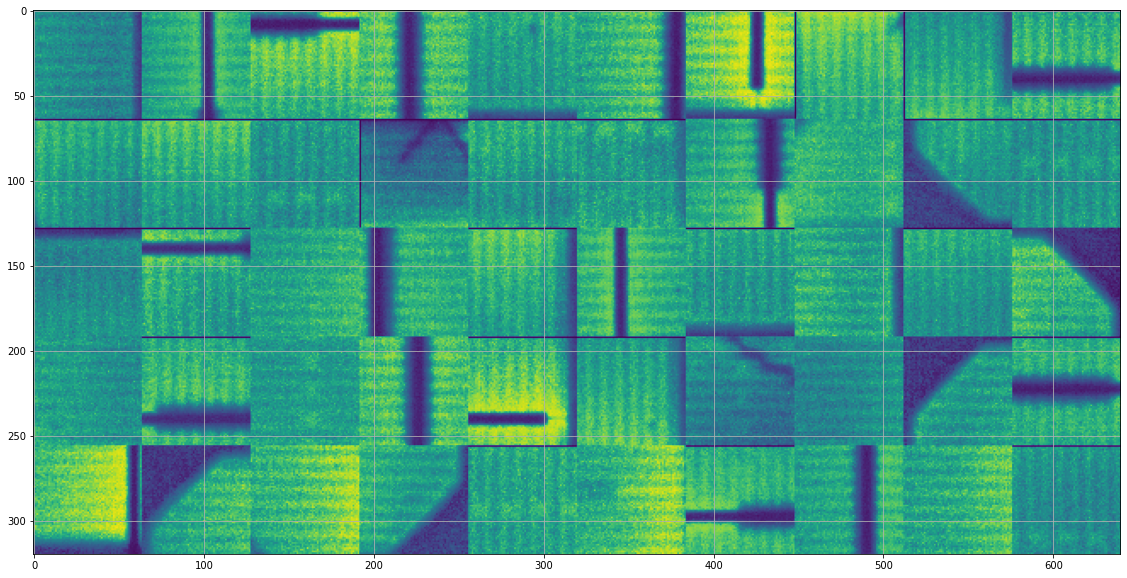

In [11]:
count=0
for x in validation_generator:
    count= count+1
    img = x[0]
    lbl = x[1]
    print(img.shape, lbl.shape)
    idxs = np.arange(50)
    plot_list(idxs,img)
    if False:
        plt.imshow(img[0,:,:,0])
        plt.title(lbl[0])
        plt.show()
    if count>3:
        break